# The two-fixed centres elliptic billiard

This example is a refinement of the [Keplerian billiard](<./The Keplerian billiard.ipynb>) described earlier in which we introduce *two* gravitational centres of attraction (rather than one) embedded in a non-rectangular billiard. Specifically, the billiard's shape is defined by the [elliptic curve](https://en.wikipedia.org/wiki/Algebraic_curve)

$$
y^2 = \left(a - x \right)\cdot\left(x - b\right)\cdot\left(x^2 + c\right),
$$

and the centres of gravity of radius $R$ are placed on the $x$ axis at coordinates $p_0$ and $p_1$. Let us pick specific numerical values for the parameters $a$, $b$, $c$, $p_0$, $p_1$ and $R$, and let us take a look at the geometry of the problem:

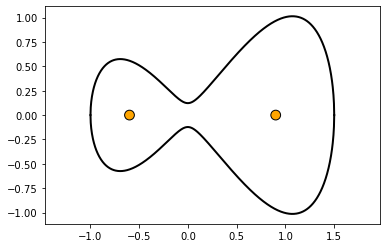

In [1]:
from matplotlib.pylab import plt
import numpy as np
plt.rcParams["figure.figsize"] = (9, 9)

# The curve's parameters.
a, b, c = -1, 1.5, .01

# The centres' positions on the x axis.
p0 = 3.*a/5.
p1 = 3.*b/5.

# The centres' radiuses.
R = 0.05

fig, ax = plt.subplots()
xrng = np.linspace(a, b, 1000)
ax.axis('equal')

# Plot the elliptic curve.
plt.plot(xrng, np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2)
plt.plot(xrng, -np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2)

# Plot the centres.
cc0 = plt.Circle((p0 , 0.), R, ec='black', fc='orange')
cc1 = plt.Circle((p1 , 0.), R, ec='black', fc='orange')
ax.add_artist(cc0)
ax.add_artist(cc1);

The elliptic curve generates on the plane a smooth, hourglass-like shape.

We will begin, as usual, with the definition of the dynamics of the system:

In [2]:
import heyoka as hy

# Introduce the symbolic state variables.
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")

# Cubes of the inverse of the distances
# from the centres of gravity.
d0_m3 = ((x - p0)**2 + y**2)**(-3/2.)
d1_m3 = ((x - p1)**2 + y**2)**(-3/2.)

# The ODEs.
eqns = [(x, vx), (y, vy),
        (vx, -(x - p0)*d0_m3 -(x - p1)*d1_m3),
        (vy, -y*(d0_m3 + d1_m3))]

In order to make the test particle bounce on the walls of the billiard and on the surface of the gravitational centres of attraction, we will need to define three event equations to detect when the particle hits the walls and the centres:

$$
\begin{cases}
y^2 - \left(a - x \right)\cdot\left(x - b\right)\cdot\left(x^2 + c\right) = 0 \\
\left( x - p_0 \right)^2 + y^2 - R^2 = 0 \\
\left( x - p_1 \right)^2 + y^2 - R^2 = 0
\end{cases}.
$$

In [3]:
# Walls.
eveq_curve = y**2 - (a - x)*(x - b)*(x**2 + c)

# Gravitational centres.
eveq_0 = (x - p0)**2 + y**2 - R**2
eveq_1 = (x - p1)**2 + y**2 - R**2

The next step is the definition of the callbacks that implement the bouncing behaviour. Like in the Keplerian billiard, we will be dealing with fully elastic collisions: whenever the test particle hits a surface, we flip the component of its velocity vector perpendicular to the surface. The normal to the surface can be computed via the gradient of the event equations.

Let us see the code:

In [4]:
# Bouncing against the first centre.
def cb_0(ta, mr, d_sgn):
    # Fetch the collision point
    # from the state vector.
    x, y = ta.state[0:2]
    
    # Compute the normal unit vector
    # using the gradient of the event
    # equation.
    grad = np.array([x-p0, y])
    grad_uvec = grad / np.linalg.norm(grad)
    
    # Compute the component of the velocity
    # across the normal vector.
    xy_vel = ta.state[2:4]
    vproj = np.dot(xy_vel, grad_uvec)
    
    # Flip it.
    Dv = -vproj*grad_uvec
    xy_vel += 2*Dv

    return True

# Bouncing against the second centre.
def cb_1(ta, mr, d_sgn):
    x, y = ta.state[0:2]
    grad = np.array([x-p1, y])
    grad_uvec = grad / np.linalg.norm(grad)
    xy_vel = ta.state[2:4]
    vproj = np.dot(xy_vel, grad_uvec)
    Dv = -vproj*grad_uvec
    xy_vel += 2*Dv
    return True

# Bouncing against the walls.
def cb_curve(ta, mr, d_sgn):
    x, y = ta.state[0:2]
    grad = np.array([2*x*(x - b)*(x - a) + (x - b)*(x**2 + c) + (x - a)*(x**2 + c), 2*y])
    grad_uvec = grad / np.linalg.norm(grad)
    xy_vel = ta.state[2:4]
    vproj = np.dot(xy_vel, grad_uvec)
    Dv = -vproj*grad_uvec
    xy_vel += 2*Dv
    return True

We can now proceed to create the events and the integrator:

In [5]:
# Construct the events.
ev_0 = hy.t_event(eveq_0, callback=cb_0, direction = hy.event_direction.negative)
ev_1 = hy.t_event(eveq_1, callback=cb_1, direction = hy.event_direction.negative)
ev_curve = hy.t_event(eveq_curve, callback=cb_curve, direction = hy.event_direction.positive)

# Construct the integrator.
ta = hy.taylor_adaptive(eqns, [0., 0., -1., .8], t_events = [ev_0, ev_1, ev_curve])

The test particle is initially placed in the neck of the billiard and moving towards the first centre of gravity. Note how, as explained in the [Keplerian billiard](<./The Keplerian billiard.ipynb>) example, we assigned specific directions to the collision events. This is done in order to avoid triggering spurious double-bounce events that would lead to the test particle exiting the box or entering one of the centres of force.

We are now ready to integrate the system for a few time units:

In [6]:
tgrid = np.linspace(0, 20, 10000)
traj = ta.propagate_grid(tgrid)[4]

Let's plot the trajectory:

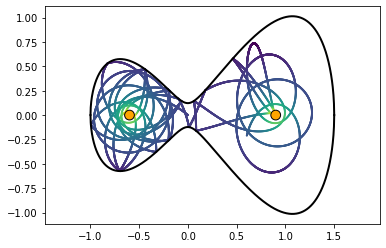

In [7]:
fig, ax = plt.subplots()
ax.axis('equal')

# Setup the billiard and the centres.
xrng = np.linspace(a, b, 1000)
plt.plot(xrng, np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2, zorder=2)
plt.plot(xrng, -np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2, zorder=2)
cc0 = plt.Circle((p0 , 0.), R, ec='black', fc='orange', zorder=2)
cc1 = plt.Circle((p1 , 0.), R, ec='black', fc='orange', zorder=2)
ax.add_artist(cc0)
ax.add_artist(cc1)

# Plot the trajectory, color-coding
# according to the velocity.
vabs = np.sqrt(traj[:, 2]**2+traj[:, 3]**2)
plt.scatter(traj[:, 0], traj[:, 1], c=vabs, s=1);

We can see how, indeed, the test particle bounces both against the walls of the billiard and the centres of gravitational attraction.

Let us now run a second integration, this time greatly increasing the initial velocity of the test particle:

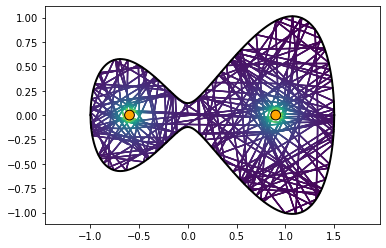

In [8]:
# Reset the time.
ta.time = 0
# Reset the state, increasing the y velocity
# with respect to the previous initial conditions.
ta.state[:] = [0, 0, -1, 8.]

# Integrate and plot.
tgrid = np.linspace(0, 20, 50000)
traj = ta.propagate_grid(tgrid)[4]

fig, ax = plt.subplots()
ax.axis('equal')

xrng = np.linspace(a, b, 1000)
plt.plot(xrng, np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2, zorder=2)
plt.plot(xrng, -np.sqrt((a - xrng)*(xrng - b)*(xrng**2 + c)), 'k-', lw=2, zorder=2)
cc0 = plt.Circle((p0 , 0.), R, ec='black', fc='orange', zorder=2)
cc1 = plt.Circle((p1 , 0.), R, ec='black', fc='orange', zorder=2)
ax.add_artist(cc0)
ax.add_artist(cc1)

vabs = np.sqrt(traj[:, 2]**2+traj[:, 3]**2)
plt.scatter(traj[:, 0], traj[:, 1], c=vabs, s=0.25);

Because we increased the initial velocity, the motion of the test particle is now almost rectilinear, and it fills up in a dense fashion the simulation domain.